In [1]:
import pandas as pd
import seaborn as sns

sns.set_theme(palette="deep")

model_title = "Qwen 3B, chain-of-thought with fallback if unknown"

mmlu_entropy_df = pd.read_parquet("../../../data/out/cot_entropy/mmlu_qwen_3b_w_fallback.parquet")

In [2]:
mmlu_entropy_df.head()

,src,answer,options,category,question,cot_content,question_id,answer_index,total_tokens,meta_cluster,base_cluster,qwen2_ans_correct,qwen2_entropies,qwen2_every_token_info,qwen2_ans_token_index,qwen2_response,qwen2_input_embeddings,qwen2_think_embeddings,qwen2_answer_embeddings
0,ori_mmlu-jurisprudence,C,['There is no distinction between the two form...,law,Which of the following criticisms of Llewellyn...,NaN,1286,2,81,Legal Interpretation,Legal Theory Interpretations,True,"[0.5892512798309326, 1.3297805786132812, 0.301...","[[{""token_idx"": 785, ""token_prob"": 2.320308522...",306,"To address this question, let's analyze each o...","{""min"": [-5.5, -7.375, -8.625, -5.1875, -7.343...","{""min"": [-5.5625, -3.984375, -5.46875, -5.2187...","{""min"": [2.25, -1.609375, -0.1298828125, -0.30..."
1,ori_mmlu-international_law,E,"['Article 19', 'Article 11', 'Article 12', 'Ar...",law,Which of the following articles are not qualif...,NaN,1293,4,38,Legal Interpretation,Constitutional Law,False,"[0.06377062201499939, 0.2561260163784027, 0.00...","[[{""token_idx"": 641, ""token_prob"": 0.000177708...",365,To determine which of these articles are not q...,"{""min"": [-5.71875, -7.71875, -9.0625, -4.96875...","{""min"": [-4.4375, -3.65625, -6.21875, -6.03125...","{""min"": [2.1875, -1.6875, 0.1533203125, -0.261..."
2,ori_mmlu-management,D,"['Work delegation', 'Workload balancing', 'Wor...",business,As what is ensuring that one individual does n...,NaN,83,3,49,Economics & Finance MCQs,Business & Marketing Queries,False,"[0.7012186646461487, 1.7263343334197998, 0.152...","[[{""token_idx"": 785, ""token_prob"": 0.004308272...",351,To determine the correct term for ensuring tha...,"{""min"": [-5.28125, -7.96875, -8.0625, -6.5625,...","{""min"": [-5.5, -5.40625, -4.15625, -5.71875, -...","{""min"": [2.015625, -1.34375, -0.46484375, 0.06..."
3,stemez-Business,J,"['$308.25', '$142.75', '$199.99', '$225.85', '...",business,Margaret Denault recently rented a truck to dr...,NaN,94,9,118,Economics & Finance MCQs,Business Finance Questions,False,"[0.33975401520729065, 1.217799186706543, 0.254...","[[{""token_idx"": 641, ""token_prob"": 1.505114141...",362,"To solve this problem, we need to calculate th...","{""min"": [-5.21875, -7.96875, -8.75, -5.4375, -...","{""min"": [-5.34375, -8.25, -5.125, -7.125, -5.4...","{""min"": [2.125, 0.072265625, -0.373046875, 0.4..."
4,stemez-Business,I,"['$60,000', '$43,200', '$1,794', '$25,000', '$...",business,The tax rate in the town of Centerville is 11(...,NaN,104,8,102,Economics & Finance MCQs,Business Finance Questions,False,"[0.23145945370197296, 0.8183579444885254, 0.26...","[[{""token_idx"": 1249, ""token_prob"": 0.93947321...",289,"To solve this problem, we need to work backwar...","{""min"": [-5.21875, -7.96875, -8.75, -6.46875, ...","{""min"": [-5.84375, -4.625, -3.828125, -5.1875,...","{""min"": [2.75, -1.9140625, -0.248046875, -0.60..."


In [3]:
mmlu_entropy_df.value_counts("qwen2_ans_token_index", dropna=False)

qwen2_ans_token_index
-1       842
 438      47
 447      45
 347      42
 429      42
        ... 
 786       1
 766       1
 723       1
 185       1
 1022      1
Name: count, Length: 899, dtype: int64

In [4]:
# Filter out unanswered questions (qwen2_ans_token_index == -1)

mmlu_entropy_df_filtered = mmlu_entropy_df[mmlu_entropy_df["qwen2_ans_token_index"] != -1]

print(f"Len = {len(mmlu_entropy_df)} before filtering and {len(mmlu_entropy_df_filtered)} after filtering")

Len = 12032 before filtering and 11190 after filtering


In [5]:
from transformers import AutoTokenizer

from reasoning_fine_tune.utils.processing import extract_cot_answer_entropy_from_row, extract_cot_answer_from_row

MODEL_NAME = "microsoft/Phi-4-mini-instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

mmlu_entropy_df_filtered["qwen2_answer"] = mmlu_entropy_df_filtered.apply(
    lambda row: extract_cot_answer_from_row(tokenizer, row, "qwen2_every_token_info", "qwen2_ans_token_index"), axis=1
)
mmlu_entropy_df_filtered["qwen2_answer_entropy"] = mmlu_entropy_df_filtered.apply(
    lambda row: extract_cot_answer_entropy_from_row(row, "qwen2_entropies", "qwen2_ans_token_index"), axis=1
)

/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_51033/2346484260.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["qwen2_answer"] = mmlu_entropy_df_filtered.apply(
/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_51033/2346484260.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["qwen2_answer_entropy"] = mmlu_entropy_df_filtered.apply(


In [6]:
# Filter out incorrectly formatted answers (answer token is not one of the options)
from reasoning_fine_tune.prompts.mmlu_single_token_answer import option_ids_w_fallback
from reasoning_fine_tune.utils.validation import keep_only_valid_and_known_answers

print(mmlu_entropy_df_filtered.value_counts("qwen2_answer", dropna=False))

mmlu_entropy_df_filtered = keep_only_valid_and_known_answers(
    mmlu_entropy_df_filtered, "qwen2_answer", option_ids=option_ids_w_fallback
)

print(mmlu_entropy_df_filtered.value_counts("qwen2_answer", dropna=False))

mmlu_entropy_df_filtered = keep_only_valid_and_known_answers(mmlu_entropy_df_filtered, "qwen2_answer")

print(mmlu_entropy_df_filtered.value_counts("qwen2_answer", dropna=False))

qwen2_answer
1        2361
3        1667
2        1214
4        1157
7        1126
5         925
6         830
8         801
9         643
0         461
A           1
b           1
h           1
maz         1
obile       1
Name: count, dtype: int64
qwen2_answer
1    2361
3    1667
2    1214
4    1157
7    1126
5     925
6     830
8     801
9     643
0     461
Name: count, dtype: int64
qwen2_answer
1    2361
3    1667
2    1214
4    1157
7    1126
5     925
6     830
8     801
9     643
Name: count, dtype: int64


In [7]:
print(mmlu_entropy_df_filtered.value_counts("qwen2_answer_entropy", dropna=False))

qwen2_answer_entropy
0.001058    2
0.365943    2
0.208896    2
0.939497    2
0.080201    2
           ..
0.005225    1
0.005230    1
0.005231    1
0.005238    1
2.180198    1
Name: count, Length: 10580, dtype: int64


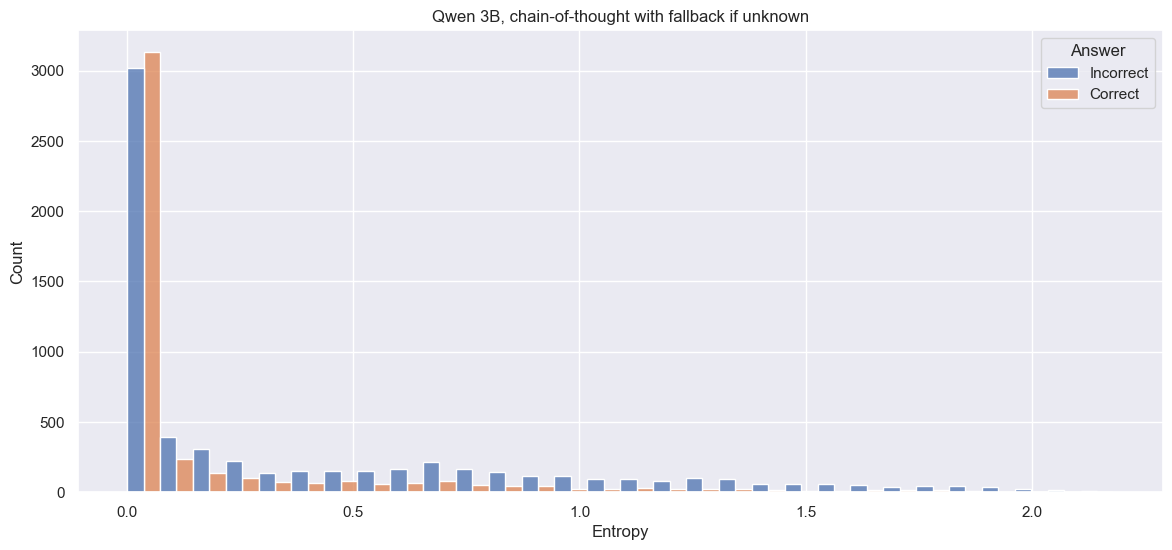

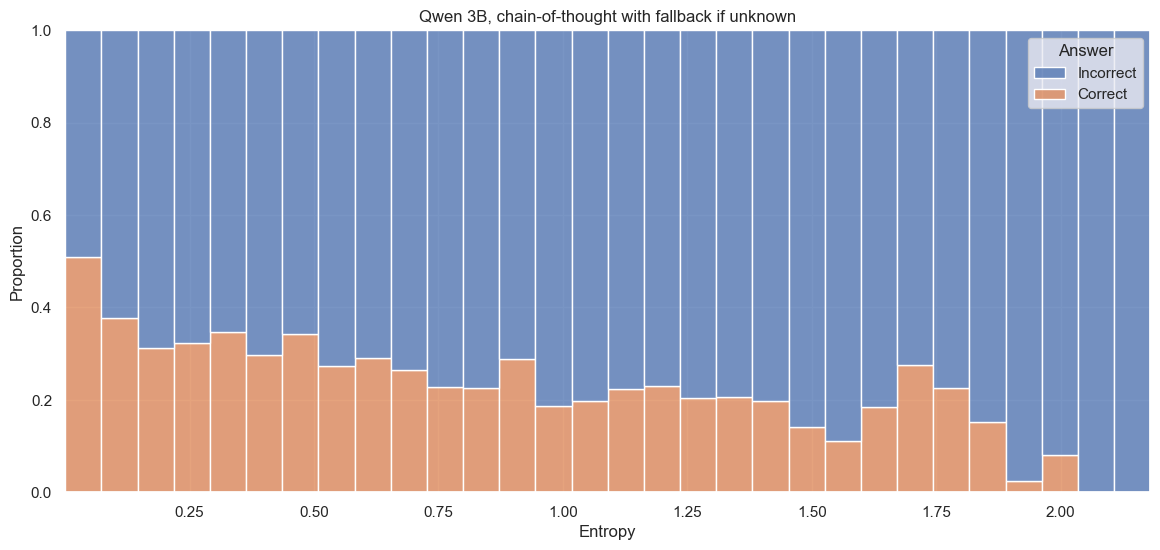

In [8]:
from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered,
    "qwen2_answer_entropy",
    "qwen2_ans_correct",
    model_name=model_title,
)

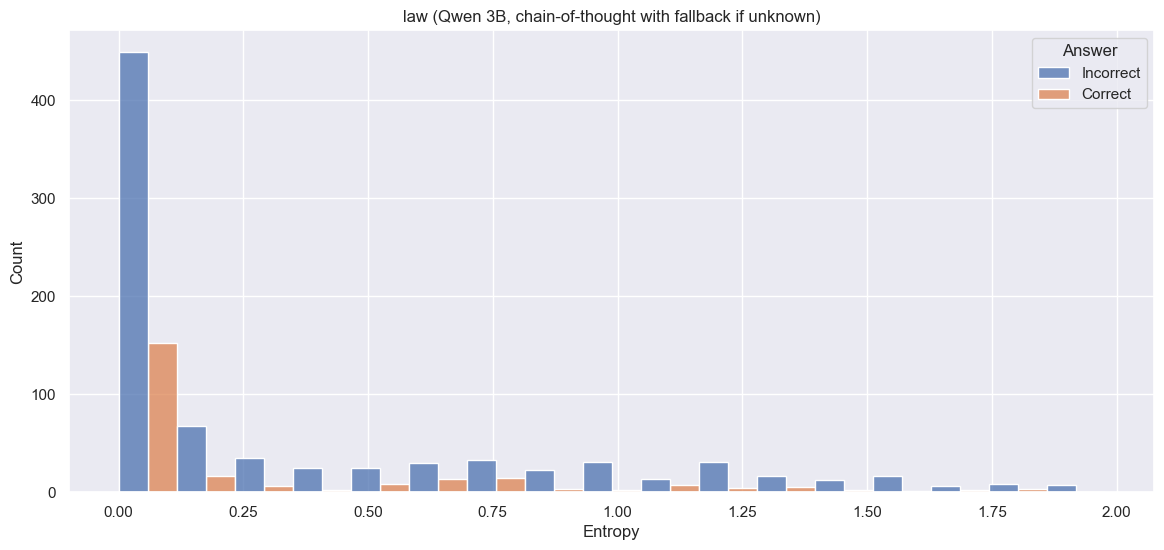

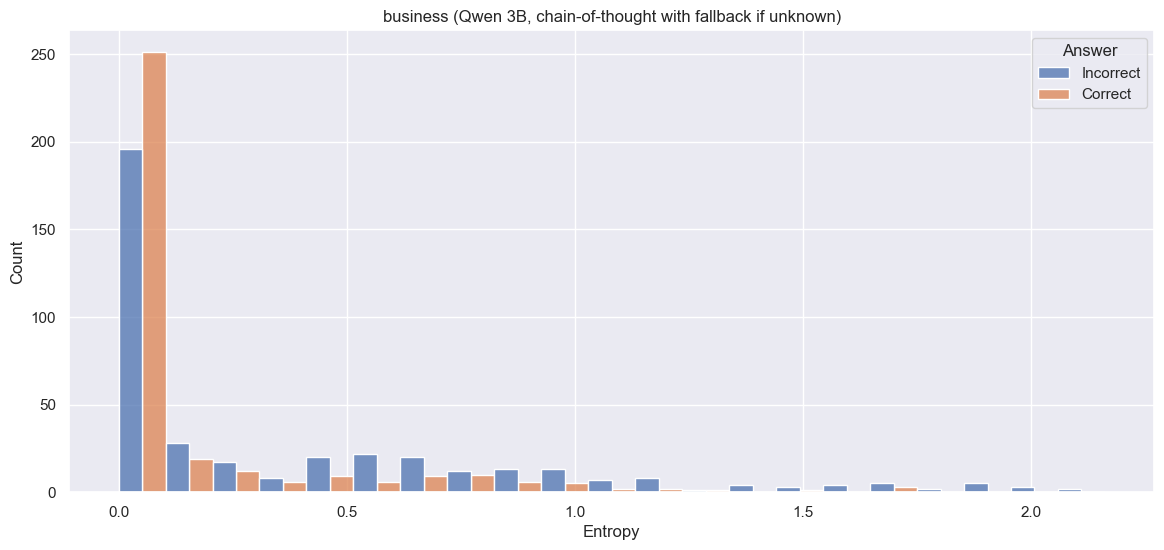

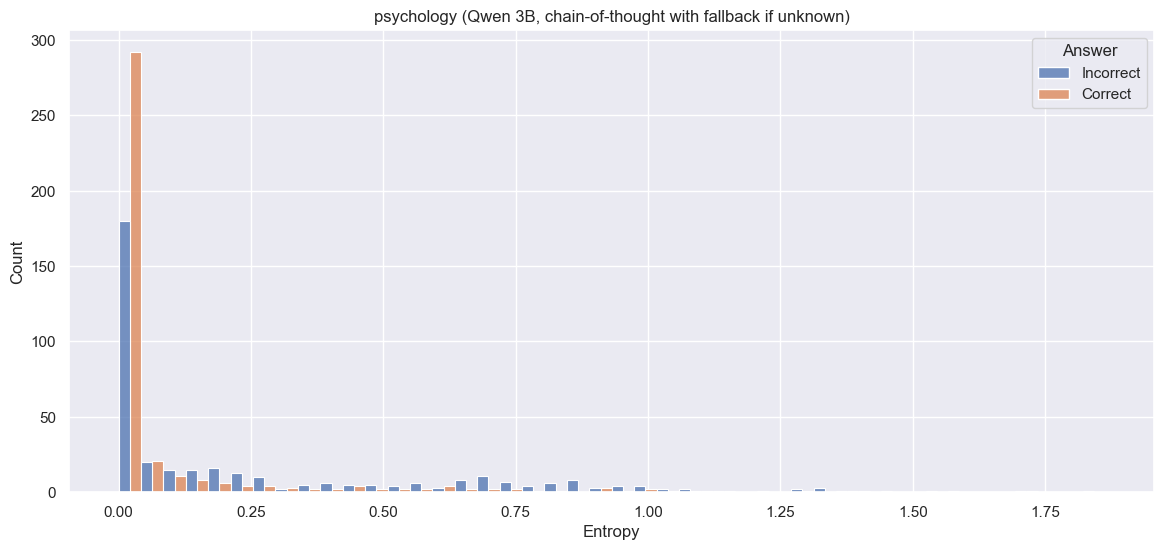

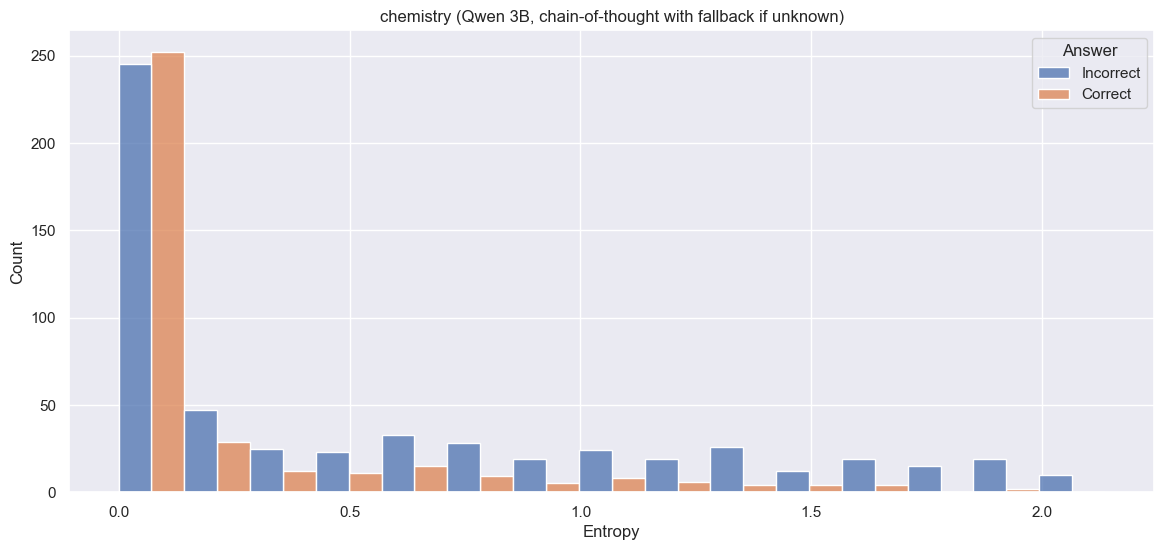

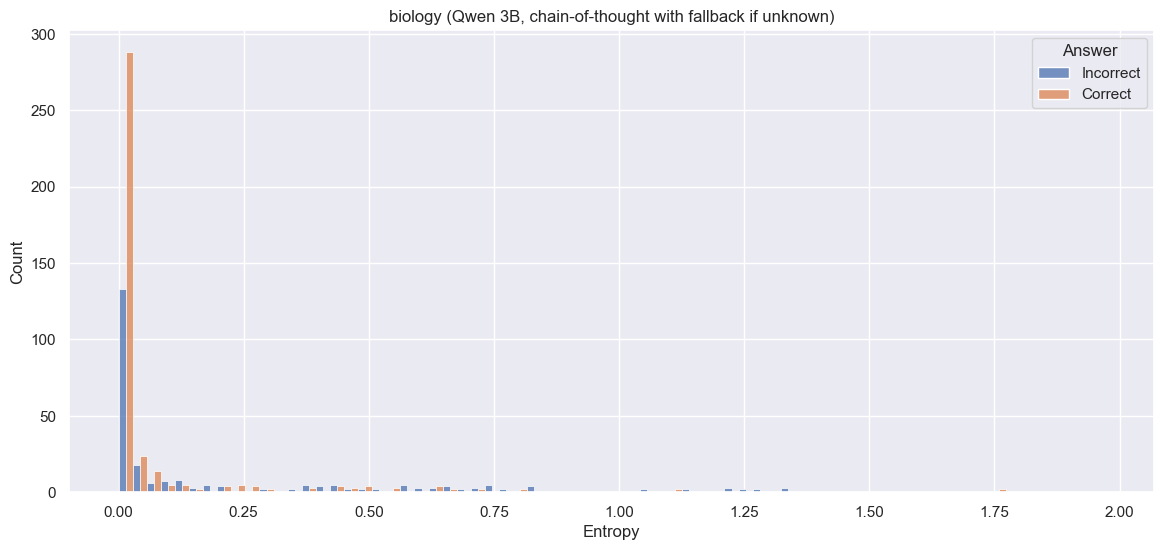

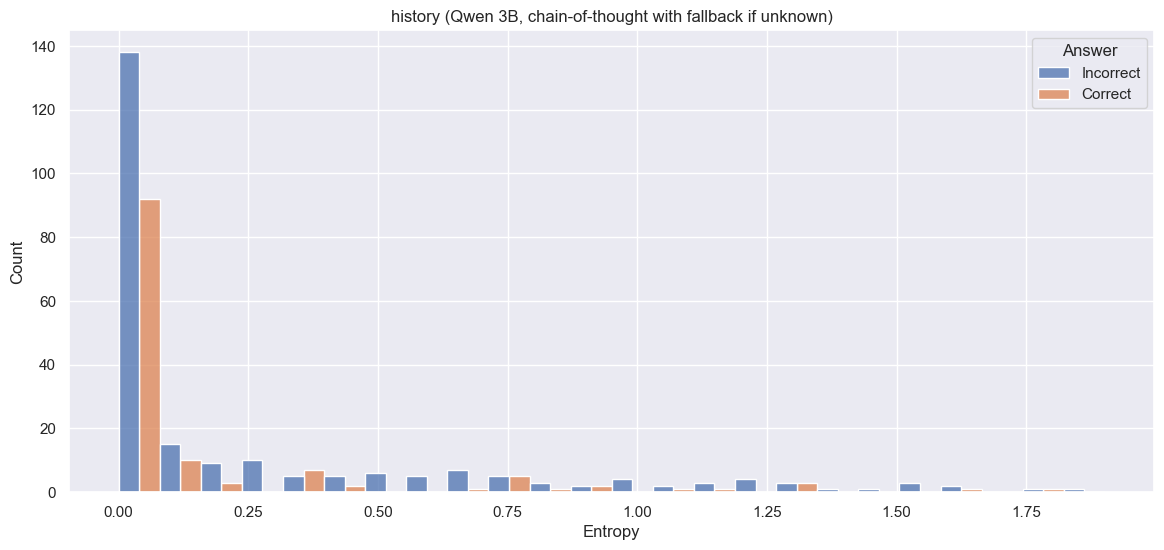

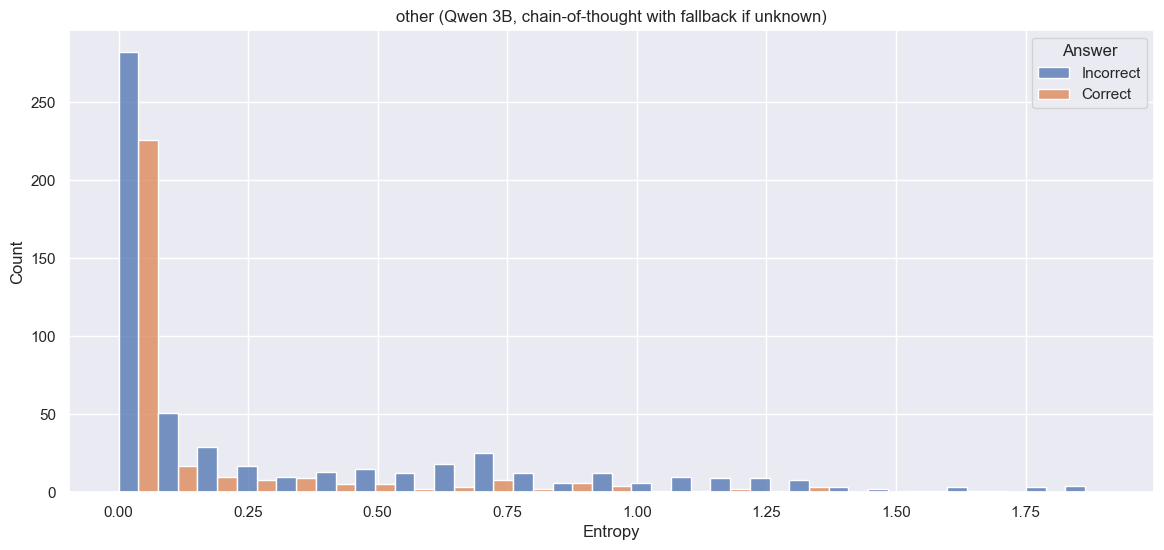

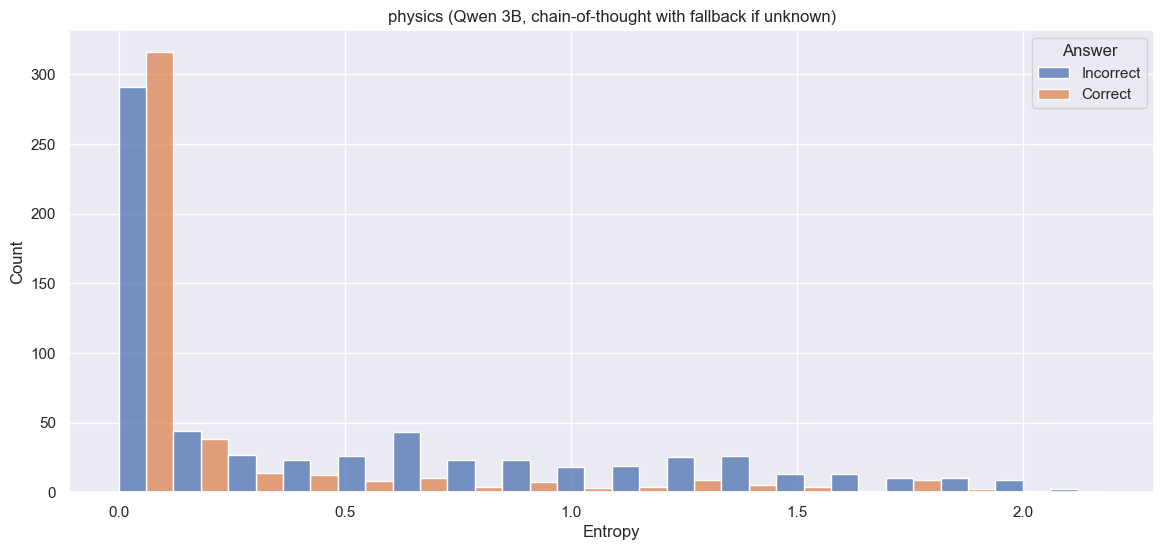

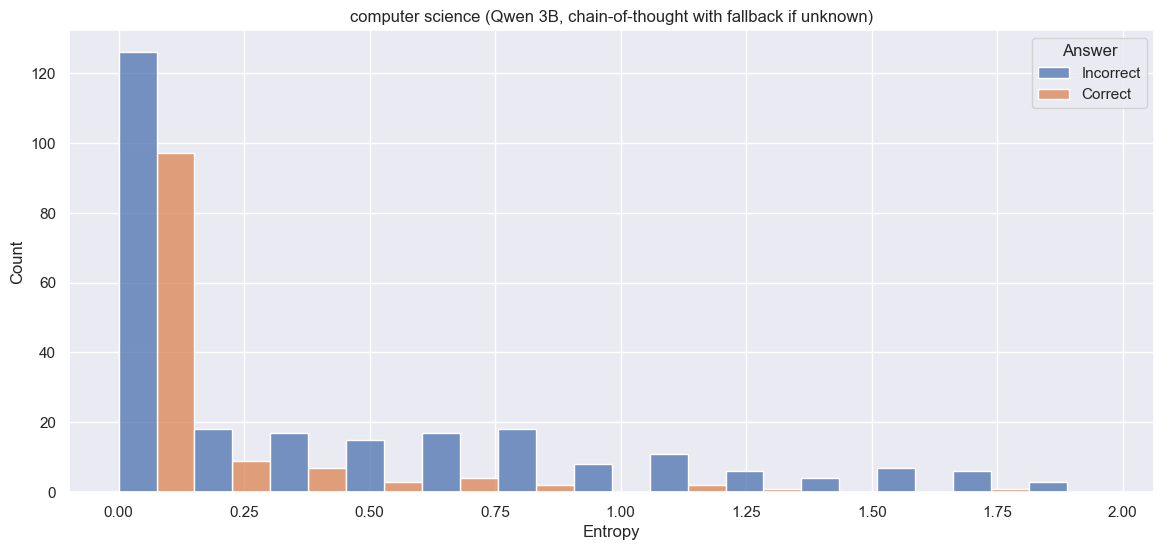

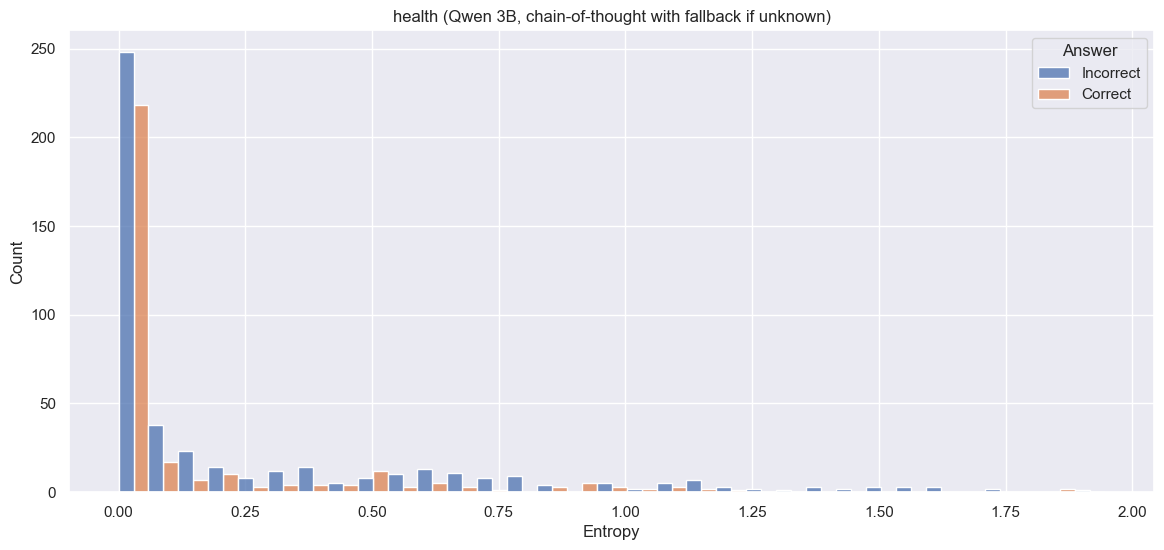

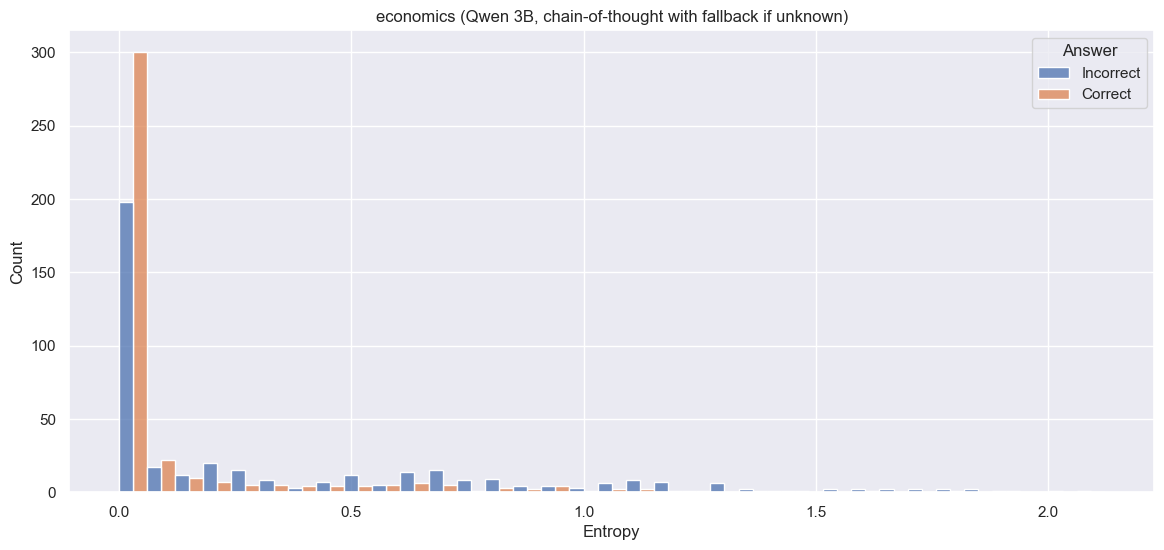

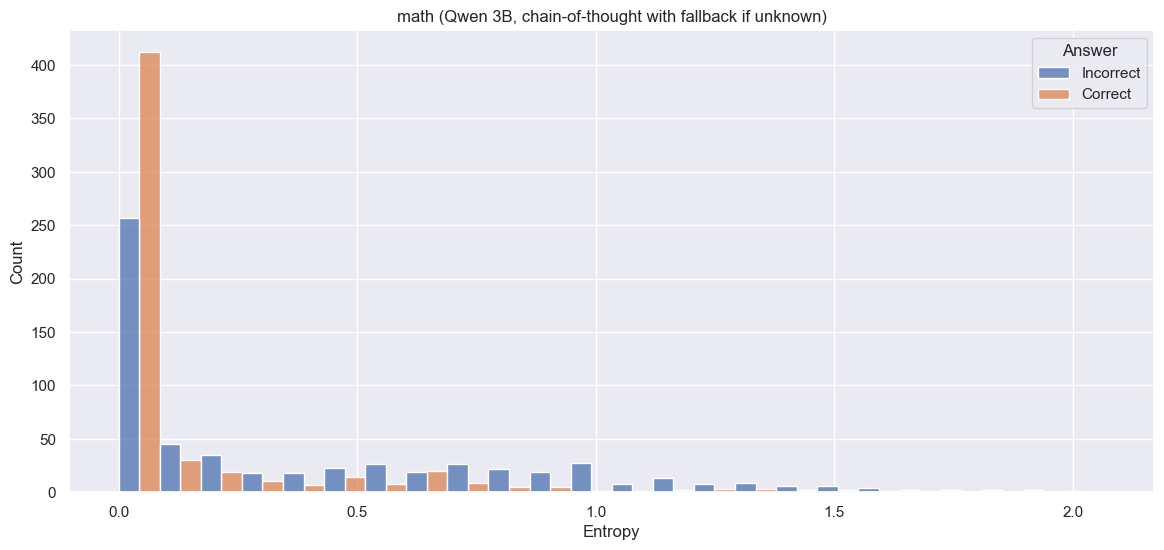

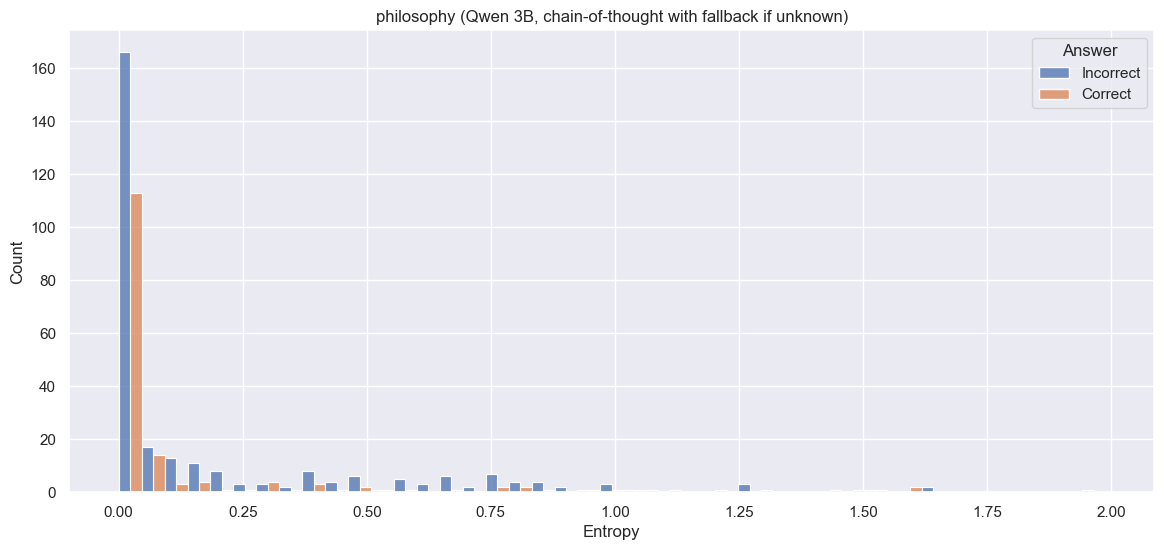

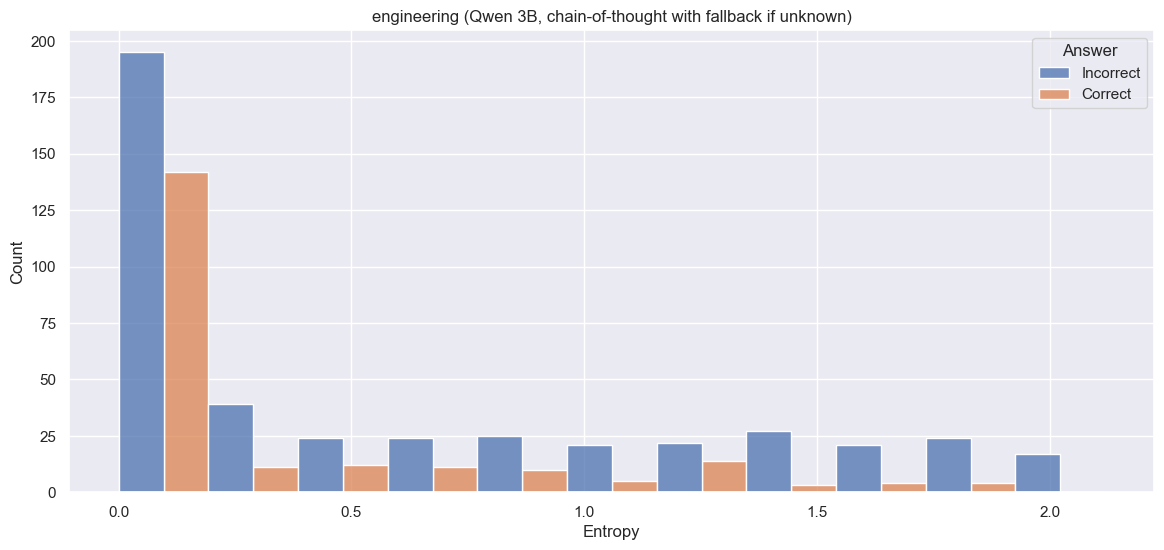

In [9]:
from reasoning_fine_tune.analysis.visualize_entropy_by_category import visualize_entropy_by_category

visualize_entropy_by_category(
    mmlu_entropy_df_filtered,
    "category",
    "qwen2_answer_entropy",
    "qwen2_ans_correct",
    model_name=model_title,
)

In [10]:
from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col="qwen2_answer_entropy",
    model_name=model_title,
)
roc_auc_res

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.669159,0.338317,10724,0.409735,"Qwen 3B, chain-of-thought with fallback if unk...",qwen2_answer_entropy
1,law,0.572629,0.145258,1071,0.225023,"Qwen 3B, chain-of-thought with fallback if unk...",qwen2_answer_entropy
2,business,0.674315,0.348630,735,0.465306,"Qwen 3B, chain-of-thought with fallback if unk...",qwen2_answer_entropy
3,psychology,0.696647,0.393294,766,0.506527,"Qwen 3B, chain-of-thought with fallback if unk...",qwen2_answer_entropy
4,chemistry,0.681416,0.362832,925,0.390270,"Qwen 3B, chain-of-thought with fallback if unk...",qwen2_answer_entropy
5,biology,0.677676,0.355352,671,0.597615,"Qwen 3B, chain-of-thought with fallback if unk...",qwen2_answer_entropy
6,history,0.609591,0.219182,365,0.356164,"Qwen 3B, chain-of-thought with fallback if unk...",qwen2_answer_entropy
7,other,0.627400,0.254800,876,0.359589,"Qwen 3B, chain-of-thought with fallback if unk...",qwen2_answer_entropy
8,physics,0.670541,0.341082,1092,0.409341,"Qwen 3B, chain-of-thought with fallback if unk...",qwen2_answer_entropy
9,computer science,0.731709,0.463418,382,0.329843,"Qwen 3B, chain-of-thought with fallback if unk...",qwen2_answer_entropy


In [11]:
from reasoning_fine_tune.analysis.join_with_masj_education_levels import join_with_masj_education_levels

mmlu_entropy_df_with_masj = join_with_masj_education_levels(mmlu_entropy_df_filtered)

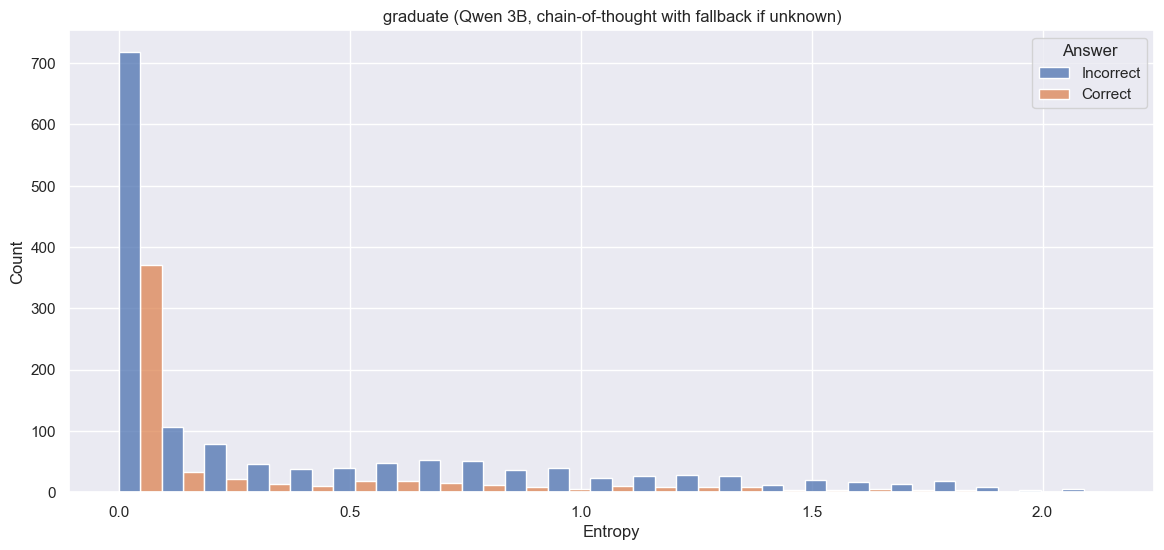

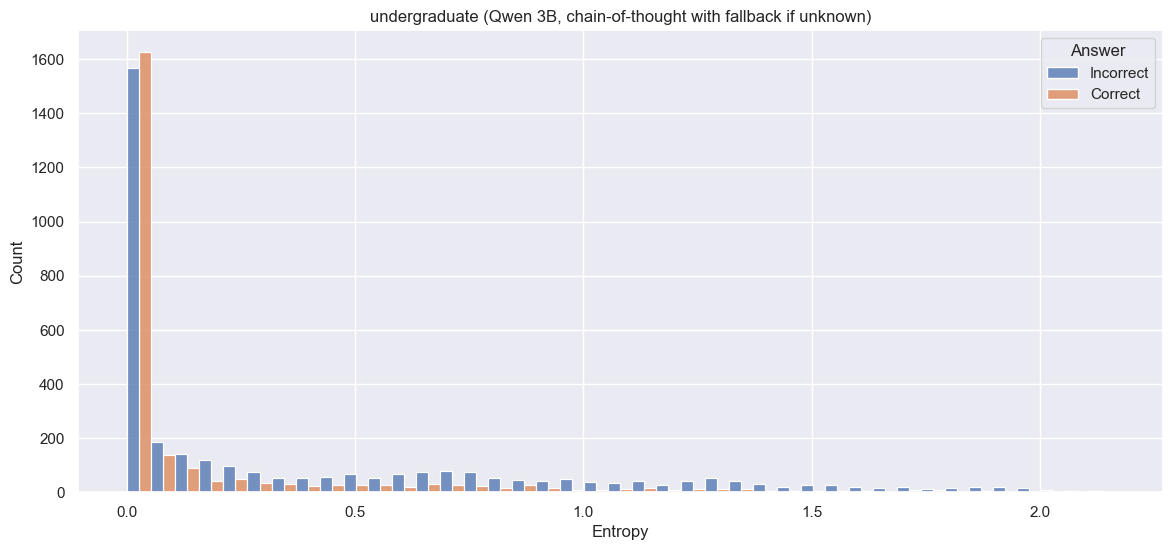

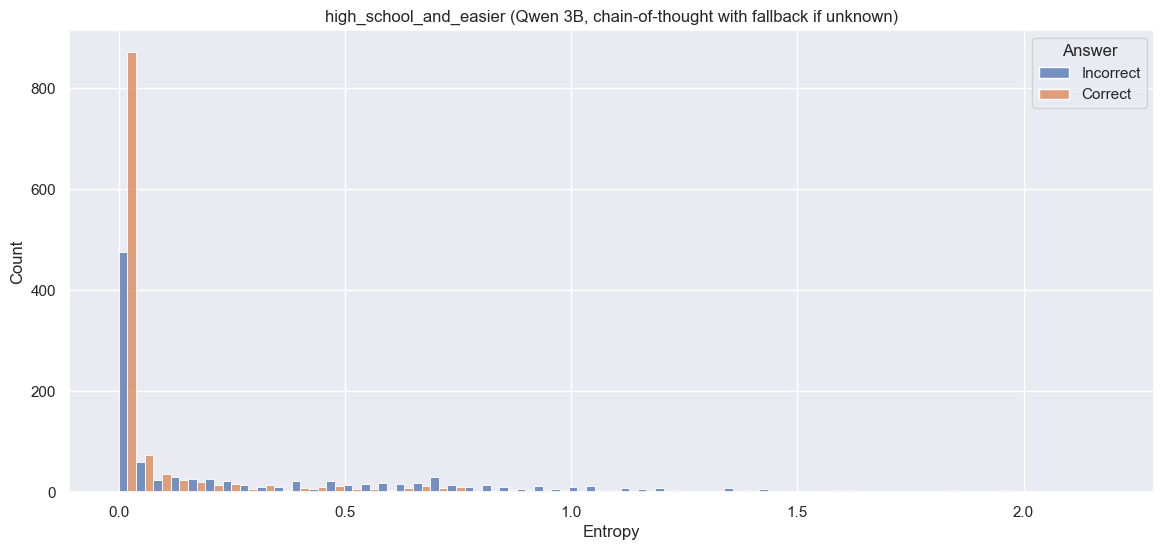

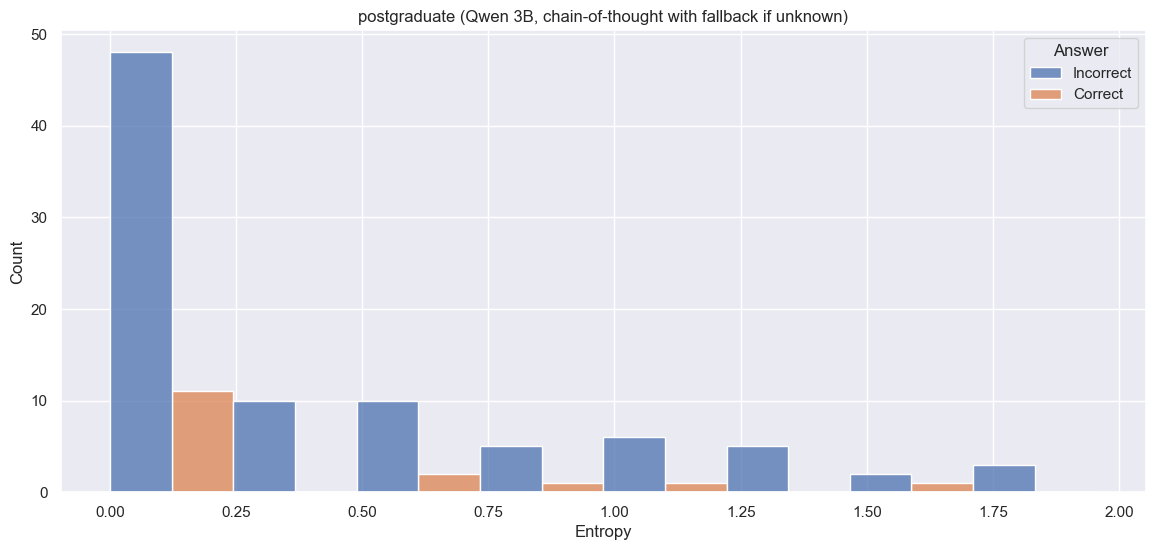

In [12]:
from reasoning_fine_tune.analysis.visualize_entropy_by_category import visualize_entropy_by_category

visualize_entropy_by_category(
    mmlu_entropy_df_with_masj,
    "masj_complexity",
    "qwen2_answer_entropy",
    "qwen2_ans_correct",
    model_name=model_title,
)

In [13]:
from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_with_masj,
    category_col="masj_complexity",
    model_answer_correct_col="qwen2_ans_correct",
    score_col="qwen2_answer_entropy",
    model_name=model_title,
)
roc_auc_res

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.669536,0.339073,10302,0.408270,"Qwen 3B, chain-of-thought with fallback if unk...",qwen2_answer_entropy
1,graduate,0.596192,0.192384,2039,0.284944,"Qwen 3B, chain-of-thought with fallback if unk...",qwen2_answer_entropy
2,undergraduate,0.666609,0.333217,5881,0.407244,"Qwen 3B, chain-of-thought with fallback if unk...",qwen2_answer_entropy
3,high_school_and_easier,0.695463,0.390927,2277,0.533158,"Qwen 3B, chain-of-thought with fallback if unk...",qwen2_answer_entropy
4,postgraduate,0.660815,0.321629,105,0.152381,"Qwen 3B, chain-of-thought with fallback if unk...",qwen2_answer_entropy
